# Statistics and regression of single cell data

## Introduction

Here we will take a hands-on approach and build upon our cell type identification efforts in step one to try out a few basic statistical analysis of the single cell data, here the preselected CD45+ fraction of cells.

## Data
We will be using processed data from step one, of CD45+ fraction of cells from four distinct regions of the gut.

## Objectives
- Is the distribution of cell types consistent across regions?
- Within monocytes, are there region-specific gene expression patterns?

## Learning Objectives
- Become familiar with accessing data via code
- Become familiar with 'big data' stored in the anndata format.
- Become familiar with filtering data via slicing of matricies.
- Get hands-on experience with the nuances of processing single cell data, including aspects that have subjective components.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading libraries

Python has a robust system of libraries and dependency checking. In the following blocks we will be loading a bunch of libraries so we can work with our data.

### Data science libraries
- `anndada` is a library for loading the raw data. It can handle data stored in a bunch of different ways, but here we will use data in the `h5ad` format that is fast (even for huge datasets), helps us keep track of the metadata (which patient, body site, outcome, etc) and information about the features (e.g., the gene names, splice variants, etc). This is a much more powerful format than excel or CSV. `h5ad` files can be opened in python and R.
- `pandas` is the adorably-named python data analysis library. Roughly equivalent to `dylpr` in R, it is an incredibly powerful system for handling data in dataframes. It can handle both data in `wide` and `long` format, supports very quick slicing, dicing, grouping, and summarizing of data--all things we will need to do.
- `scanpy` is the python single-cell sequencing data analysis library. It helps us do a bunch of things we will need to do to achieve our goal here today.
- `numpy` is the Python numerical library. It is a super powerful library to do math things, like log-transformations.

In [2]:
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np

### Statistical libraries

- `scipy` is the python 'science' library, filled with useful basic stastical tools (eg., t-test, odds-ratio calculators, etc.)
- `statsmodels` contains a ton of useful regression, prediction, and other statistical tools all nicely with a standardized interface.
- `multipletests` submodule. This is a neat module that can do a variety of multiple comparisons corrections.

In [3]:
import scipy
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

### Gene set enrichment library

- `gseapy` is a nice library that can use publicly available gene set enrichment tools. "Which cells have these genes expressed?" "What does this gene do?"

In [4]:
import gseapy as gp

### Graphing and figure libraries

These two libaries combined are roughly equivalent to what `ggplot` can do in R
- `matplotlib` is the more basic plotting library, able to make a variety of basic plot types (scatter, line, bar, errorbar, etc.)
- `seaborn` is built upon matplotlib, and can make more sophisticated plots (swarm, strip, violin, heatmap, clustermap, etc.)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')



scanpy==1.9.8 anndata==0.10.5 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


## Load data

Here we are loading our CD45+ lymphocyte data that we proccessed in Step 1 and then saved in `h5ad` format. We can see the data, metadata, and prior analyses are all there and neat and tidly organized. It also should load quite quickly despite all of the data present.

In [7]:
cca_L = ad.read_h5ad(
    'data/Colon_cell_atlas.CD45P.clustered.h5ad'
)
cca_L

AnnData object with n_obs × n_vars = 9079 × 16903
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'leiden'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_DEG', 'leiden_colors', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups__logreg', 'rank_genes_groups__logreg__summary', 'rank_genes_groups__wilcoxon', 'rank_genes_groups__wilcoxon__summary', 'region_colors', 'region_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: '10K', 'raw_count'
    obsp: 'connectivities', 'distances'

## Cell type count by region.

We will now focus on the `.obs` part of the `anndata` object. That is the per-cell metadata, and stored as a `pandas` `DataFrame`. 
There are two columns in there, `region` (where was this collected) and `leiden` which is our cell type identification from the prior step.
Let's use the powerful `groupby` and `count()` tools of `pandas` to add up how many cells belong to each cell type in each region...


In [8]:
cca_L.obs.head(2)

,Fraction,batch,donor,gender,region,n_counts,percent_mito,n_genes,n_genes_by_counts,total_counts,total_counts_MT,pct_counts_MT,leiden
index,,,,,,,,,,,,,
AAACCTGCAAGGCTCC-1-4861STDY7208411,CD45P,4861STDY7208411,298c,Male,Caecum,17505.0,0.017481,1602,1602,17505,306,1.748072,B-int
AAACCTGCACTTCTGC-1-4861STDY7208411,CD45P,4861STDY7208411,298c,Male,Caecum,9106.0,0.009884,872,872,9106,90,0.988359,B-int


In [9]:
celltype_by_region = cca_L.obs.groupby([
    'region',
    'leiden',
]).count().Fraction.reset_index().pivot(
    index='region',
    columns='leiden',
    values='Fraction',
).fillna(0).astype(int)
celltype_by_region

leiden,B-int,Plasma,B-naive,DC,Monocyte,Plasma-Kappa,Basophil / Mast / ILC
region,,,,,,,
Caecum,1530,879,39,0,39,27,20
Sigmoid,906,1501,6,209,35,71,37
Transverse,1798,1518,26,0,89,33,55
mLN,10,7,219,0,17,8,0


#### Visualization

We will now take the count-table we made and use seaborn (the graphing library) to display it as a heatmap, focused in on the distribution of cell types in a given region.


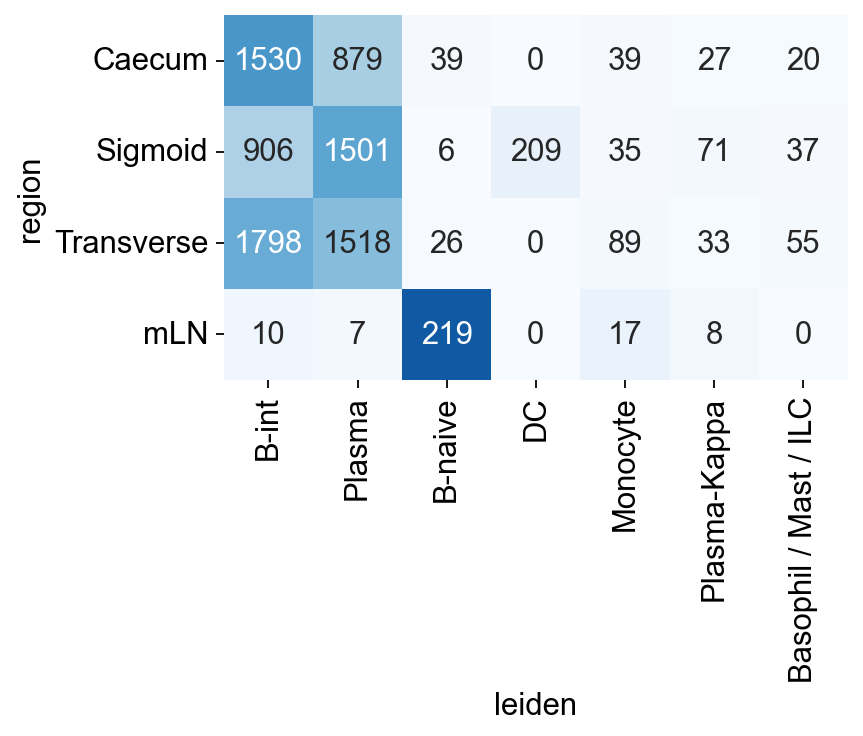

In [10]:
fig, ax = plt.subplots(
    figsize=(5,3)
)
sns.heatmap(
    data=(celltype_by_region.T / celltype_by_region.sum(axis=1)).T,
    annot=celltype_by_region,
    fmt='d',
    cmap='Blues',
    cbar=False,
    vmin=0,
    vmax=1,
    ax=ax
)
ax.grid(False)
plt.show()

Does this biologically ring true to you, fit your expectation for a 'healthy adult human gut'?

## Differences in monocytes by location in the gut?

Let's narrow down and test the hypothesis that gene expression in lymphocytes varies by region (mLN, Transverse, Sigmoid, or cecum).

First step is to narrow down the overall dataset just to monocytes. 

We will use slicing, and the cell type information we have stored in the `.obs` metadata to get just the monocytes. We will make a copy so we can modify the monocyte data alone.

In [11]:
monocyte = cca_L[
    (cca_L.obs.leiden == 'Monocyte')
].copy()
monocyte

AnnData object with n_obs × n_vars = 180 × 16903
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'leiden'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_DEG', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups__logreg', 'rank_genes_groups__logreg__summary', 'rank_genes_groups__wilcoxon', 'rank_genes_groups__wilcoxon__summary', 'region_colors', 'region_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: '10K', 'raw_count'
    obsp: 'connectivities', 'distances'

### Filtering

We will use scanpy's filtering function to get rid of genes not expressed in any monocytes--genes in this case expressed in fewer than 10 cells. That is moderately aggressive given teh total cells by site observed, but will let us narrow down to the genes most represented in these cells.

In [12]:
# Get rid of genes not really observed in this dataset
sc.pp.filter_genes(
    monocyte, 
    min_cells=10,
)
monocyte

filtered out 8313 genes that are detected in less than 10 cells


AnnData object with n_obs × n_vars = 180 × 8590
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'leiden'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_DEG', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups__logreg', 'rank_genes_groups__logreg__summary', 'rank_genes_groups__wilcoxon', 'rank_genes_groups__wilcoxon__summary', 'region_colors', 'region_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: '10K', 'raw_count'
    obsp: 'connectivities', 'distances'

### Dimensionality reduction.

We will use `scanpy` and normalzied variance to identify 'highly variable genes' in the monocytes, attempting to reduce the number of genes we will consider down to something more suitable for the number of cells / observations we have.

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


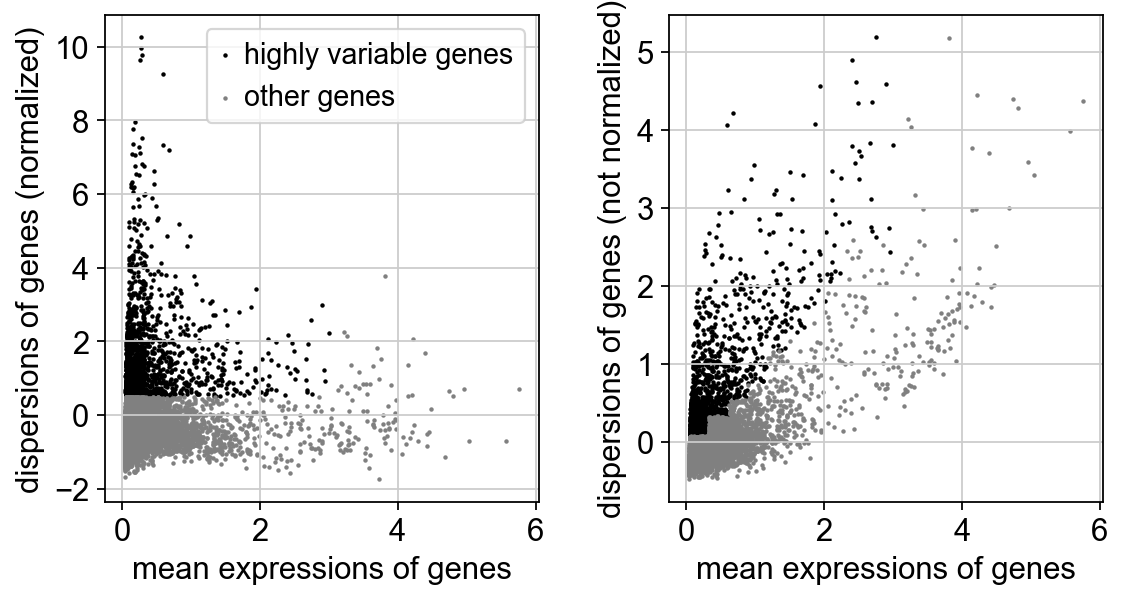

In [13]:
## Find 'highly variable genes'
sc.pp.highly_variable_genes(
    monocyte, 
    min_mean=0.0125, 
    max_mean=3, 
    min_disp=0.5
)
sc.pl.highly_variable_genes(
    monocyte
)

#### Slicing of the var / genes

Thus far, we have sliced by row / cell to get to subsets of observations. But now we would like to subset the genes. We can do that too, and it is also very quick!

In [14]:
monocyte[
    : # : means 'take everything'. It's a slice without a slice. "Take all rows / cells"
    , # The comma switches from rows to columsn (genes)
    monocyte.var.highly_variable # Only keep the var / genes that are highly variable.
].layers['raw_count'][
    0:10,
    0:10
].todense()

matrix([[0, 0, 1, 3, 0, 0, 0, 0, 3, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 3, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 2, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 6, 0, 0, 0, 0, 2, 0, 1],
        [0, 0, 2, 0, 0, 0, 2, 0, 2, 3]], dtype=int32)

### Association considerations:
Like most single-cell data, it's very low count and mostly zeros. Further, given a relatively high limit of detection, a lot of those zeros are not actually zero--but instead 'transcription below the limit of detection'.

These can cause issues if you treat the expression here as a comparison of means (e.g., GLM, logistic regression, etc.), as you are most likely going to be comparing a mean mostly made up of zeros to a mean also made up of zeros. 

Another consideration is that while there are many cells, they ultimately represent repeated sampling of a handful of biological replicates (donors) and spread over multiple batches in processing. 

The appropriate statistical test to use here is non-trivial. I often start with something very basic and simple. For this question, I would start with a detected-or-not contingency table and chisquare, and then move on to fancier techniques, but this is far from standard. 


### Chisquared on detected or not.

Loop through the raw count matrix of each 'highly variable gene' in monocytes, build a contingency table, and run chisquare on it to get a p-value for the distribution observed.

In [15]:
monocyte_region_cs_p = {}
monocyte_var_genes = monocyte.var_names[
    monocyte.var.highly_variable
]
for g_i, g_data in enumerate(monocyte[
    :,
    monocyte.var.highly_variable
].layers['raw_count'].T):
    g_data = pd.merge(
        pd.DataFrame(
            np.ravel(g_data.todense()),
            index=monocyte.obs_names,
            columns=[monocyte_var_genes[g_i]]
        ),
        monocyte.obs[['region', 'donor', 'batch']],
        left_index=True,
        right_index=True,
    )
    g_data['detected'] = g_data[monocyte_var_genes[g_i]] > 0
    g_ct = g_data.groupby([
        'detected',
        'region',
    ]).count().reset_index().pivot(
        columns='detected',
        index='region',
        values=monocyte_var_genes[g_i]
    ).fillna(0).astype(int)
    g_cs = scipy.stats.chi2_contingency(
        g_ct
    )
    monocyte_region_cs_p[
        monocyte_var_genes[g_i]
    ] = g_cs.pvalue


### Convert outputs to a dataframe and do a multiple-comparisons correction.

In [16]:
monocyte_cs_df = pd.DataFrame(
    [
        {
            'gene': k,
            'p': v
        }
        for k,v in monocyte_region_cs_p.items()
    ]
)
monocyte_cs_df['q'] = multipletests(
    monocyte_cs_df.p,
    method='fdr_bh',
)[1]
monocyte_cs_df[
    monocyte_cs_df.q < 0.01
].sort_values('q')

,gene,p,q
403,JCHAIN,1.518919e-26,2.472801e-23
1264,ATP6V0C,6.920575e-10,5.633348e-07
83,NBPF26,4.519713e-09,2.452698e-06
781,FABP4,1.756267e-06,7.148006e-04
125,FCGR2B,2.528556e-06,8.232979e-04
116,FCER1A,4.340534e-06,1.177731e-03
641,MRPS24,8.871561e-06,2.063272e-03
1434,NFATC1,1.385620e-05,2.819737e-03
523,CYFIP2,2.501767e-05,4.525418e-03
709,GPR34,3.758988e-05,6.119632e-03


### Plot the results, making a plot function just for monocytes.

In [17]:
try:
    del plot_monocyte_gene
except:
    pass
def plot_monocyte_gene(gene_id):
    gene_df = pd.merge(
        pd.DataFrame(
            np.ravel(
                monocyte[
                    :,
                    monocyte.var_names.get_loc(gene_id)
                ].X.todense()
            ),
            columns=['log_scaled'],
            index=monocyte.obs_names
        ),
        monocyte.obs[['region', 'donor', 'batch']],
        left_index=True,
        right_index=True,
    )
    gene_df['RP10K'] = np.ravel(
        monocyte[
            :,
            monocyte.var_names.get_loc(gene_id)
        ].layers['10K'].todense()
    )
    gene_df['detected'] = gene_df.RP10K > 0

    gene_ct = gene_df.groupby([
        'detected',
        'region',
    ]).count().reset_index().pivot(
        columns='detected',
        index='region',
        values='donor'
    ).fillna(0).astype(int)
    # --

    fig, axes = plt.subplot_mosaic(
        [
            ['RP10K', 'log_scaled', 'CT']
        ],
        figsize=(9,3),
    )
    sns.stripplot(
        data=gene_df,
        x='RP10K',
        y='region',
        ax=axes['RP10K'],
        s=3,
        color='k'
    )
    sns.stripplot(
        data=gene_df,
        x='log_scaled',
        y='region',
        ax=axes['log_scaled'],
        s=3,
        color='k'
    )
    axes['log_scaled'].set_yticklabels([])
    axes['log_scaled'].set_ylabel(None)

    sns.heatmap(
        data=(gene_ct.T / gene_ct.sum(axis=1)).T,
        annot=gene_ct,
        fmt='d',
        cmap='Blues',
        vmin=0,
        vmax=1,
        cbar=False,
        ax=axes['CT']
    )
    axes['CT'].grid(False)
    axes['CT'].set_yticklabels([])
    axes['CT'].set_ylabel(None)
    plt.suptitle(
        gene_id
    )
    plt.show()


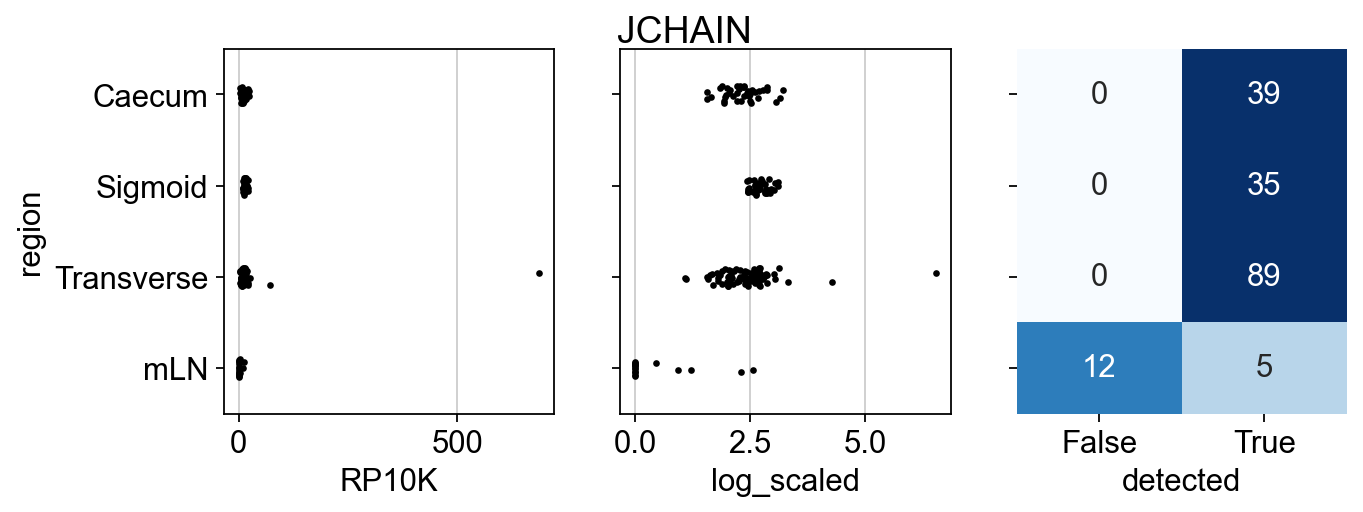

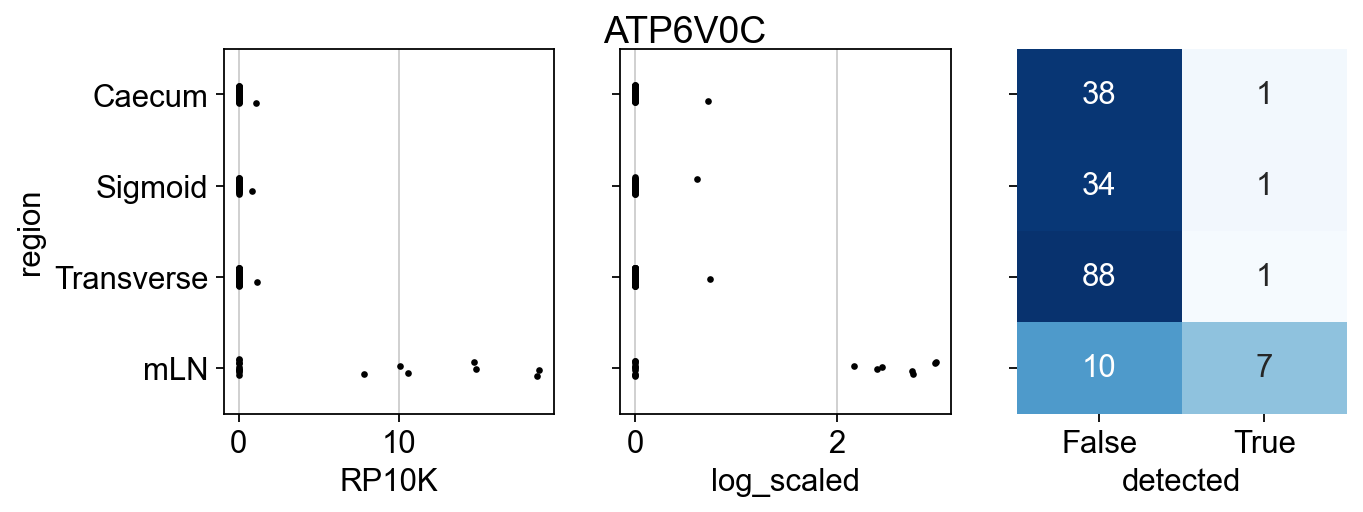

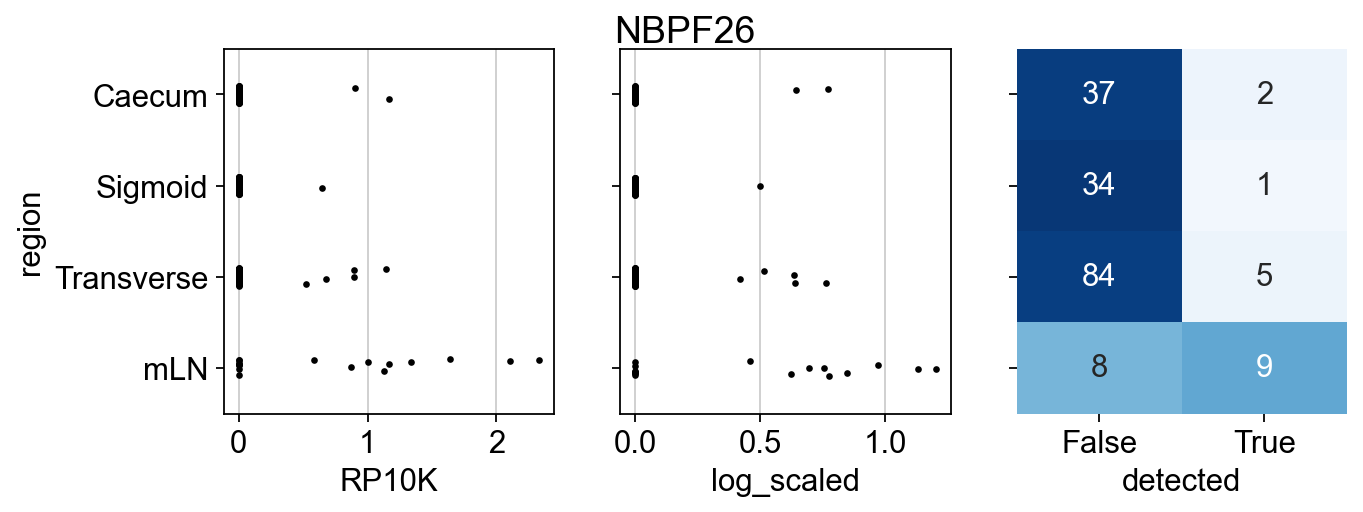

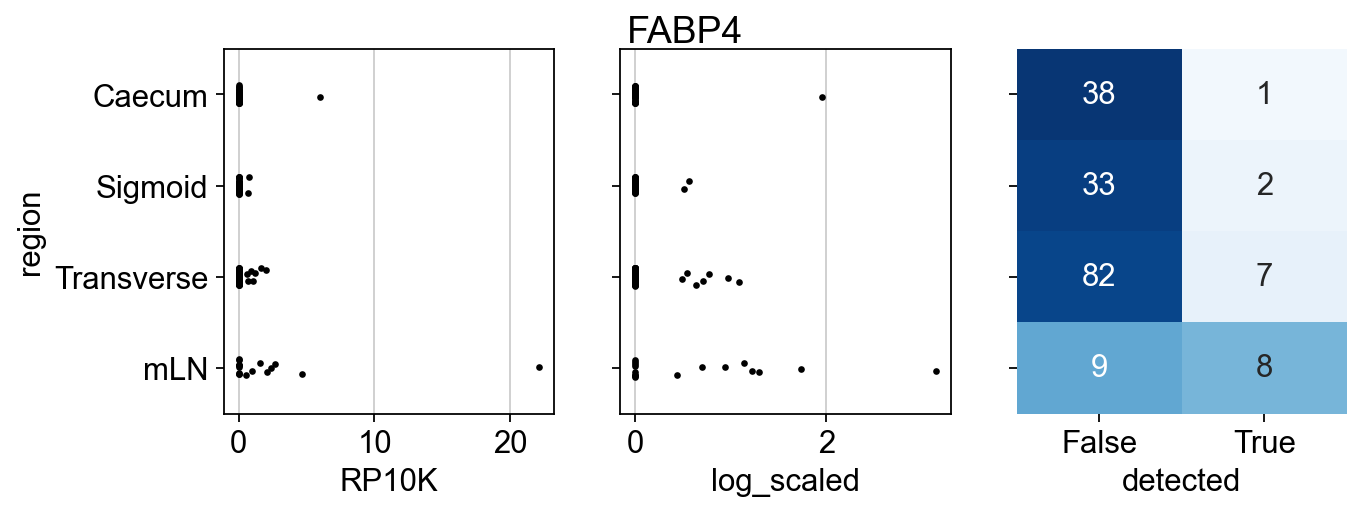

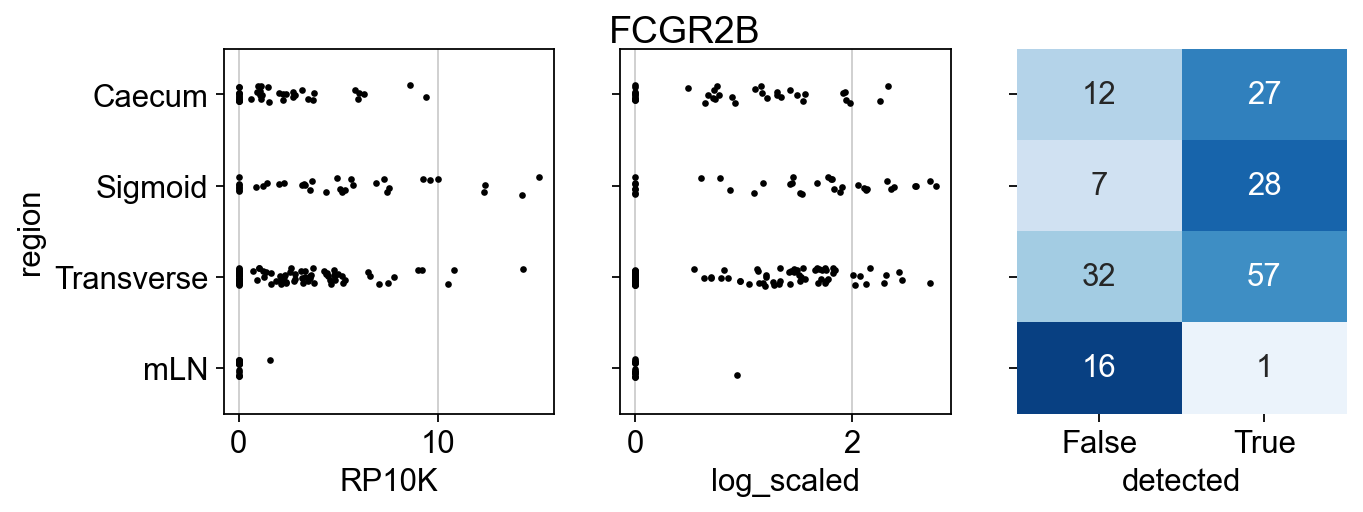

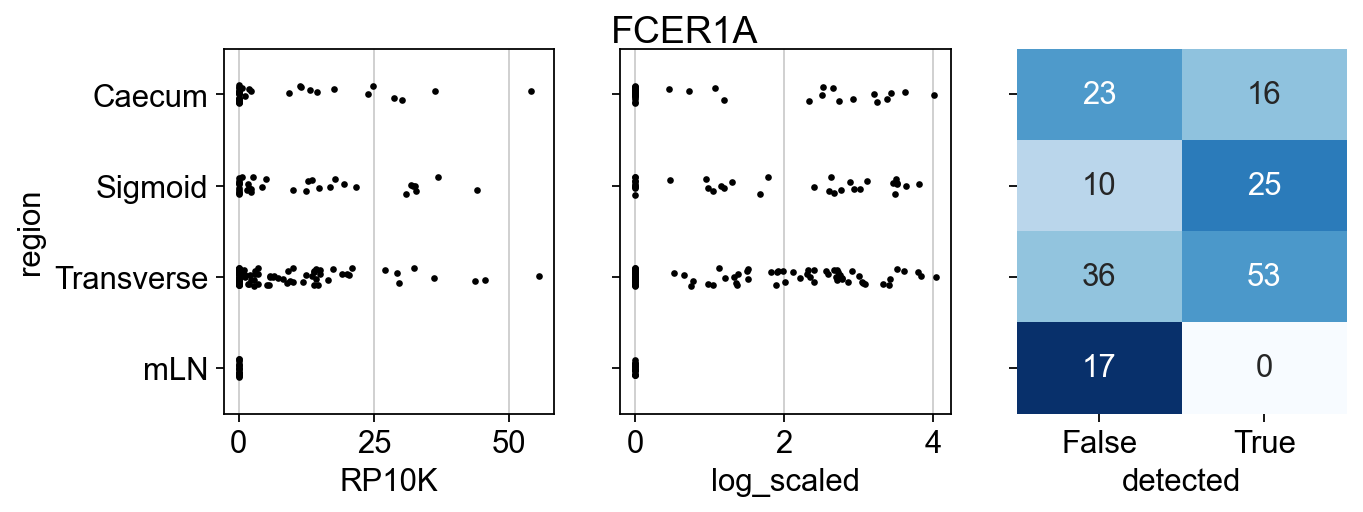

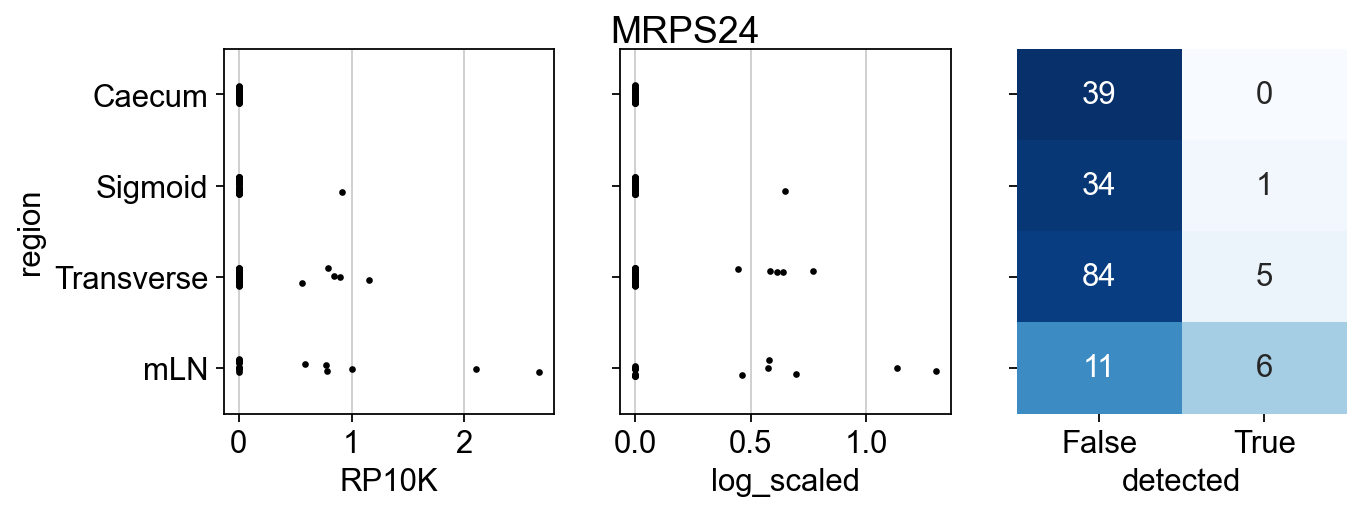

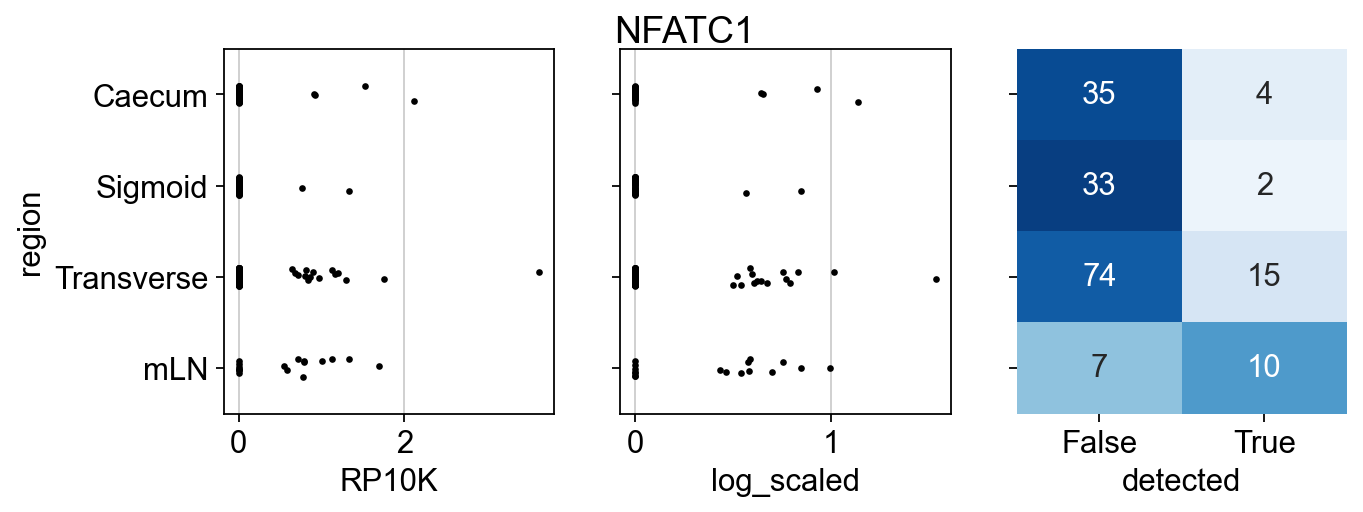

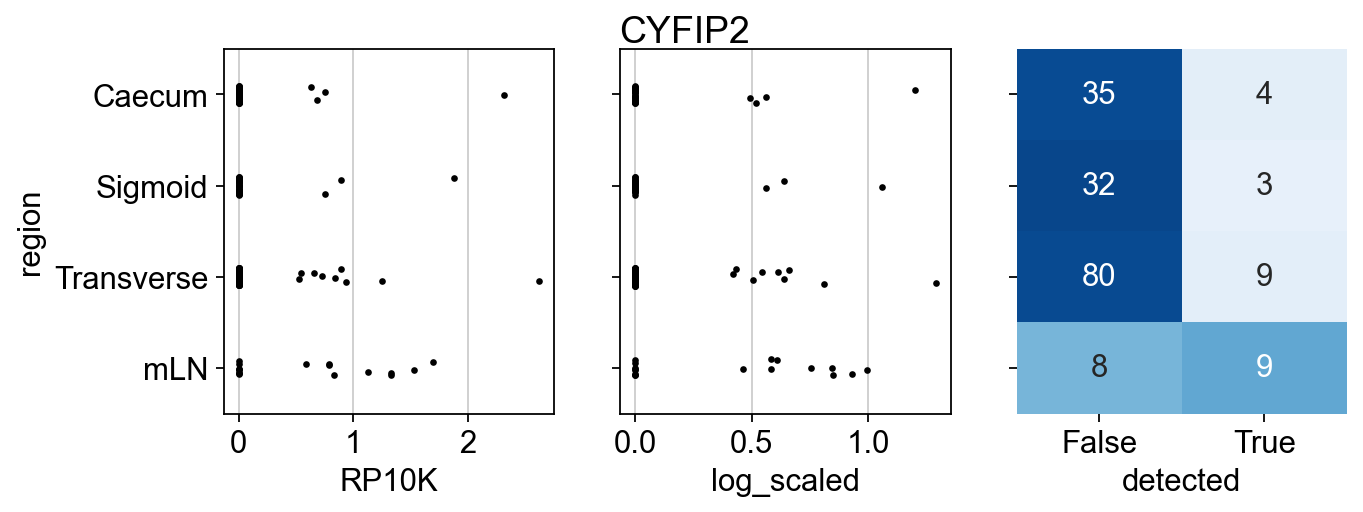

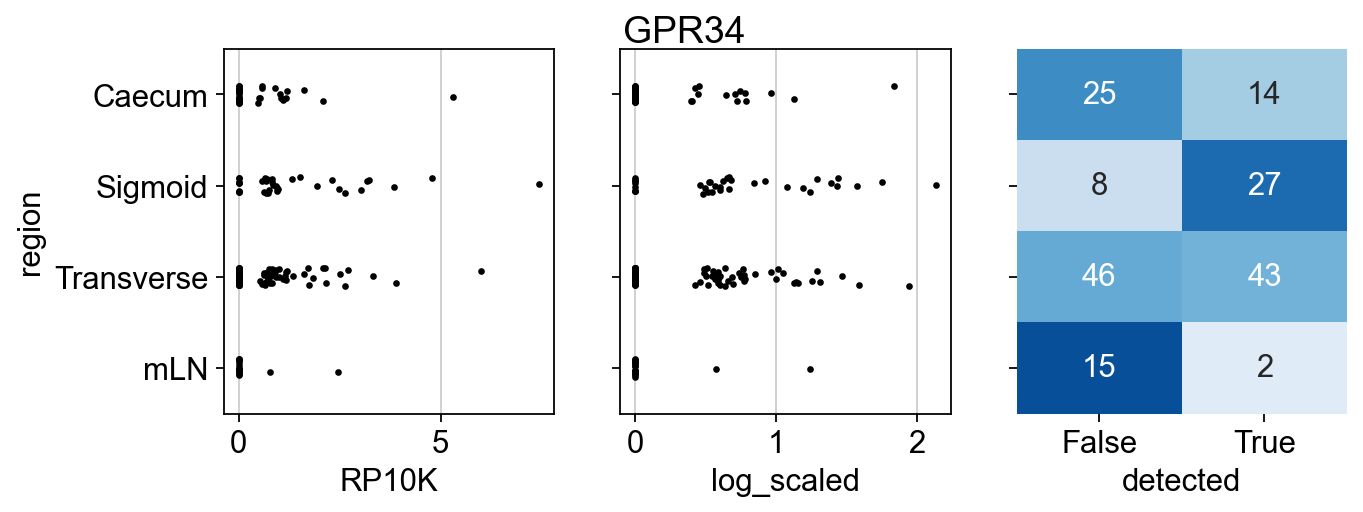

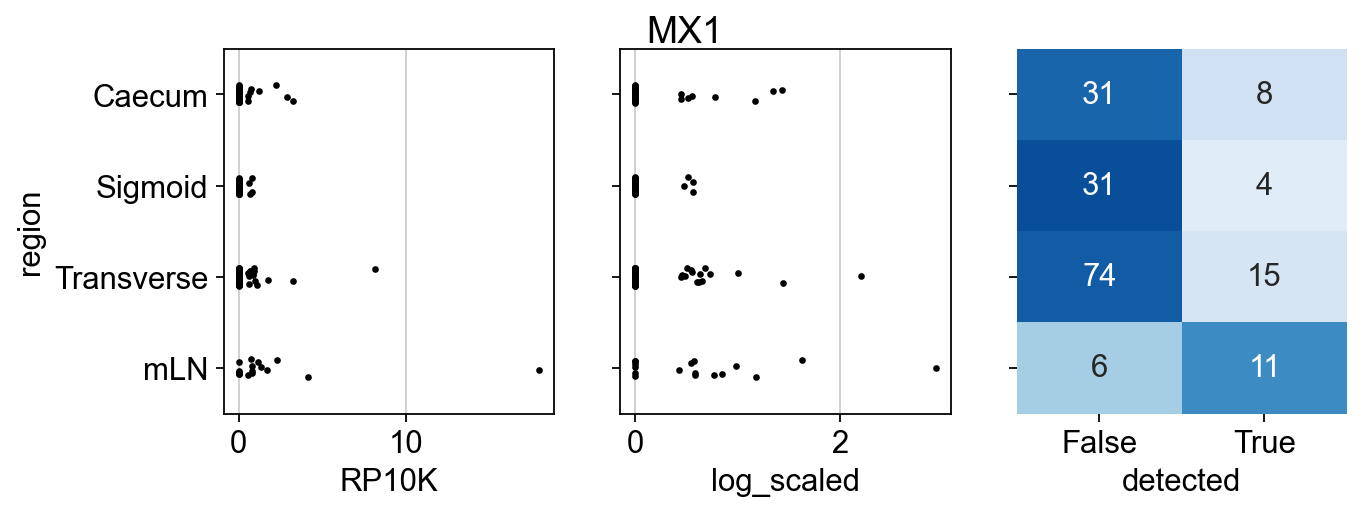

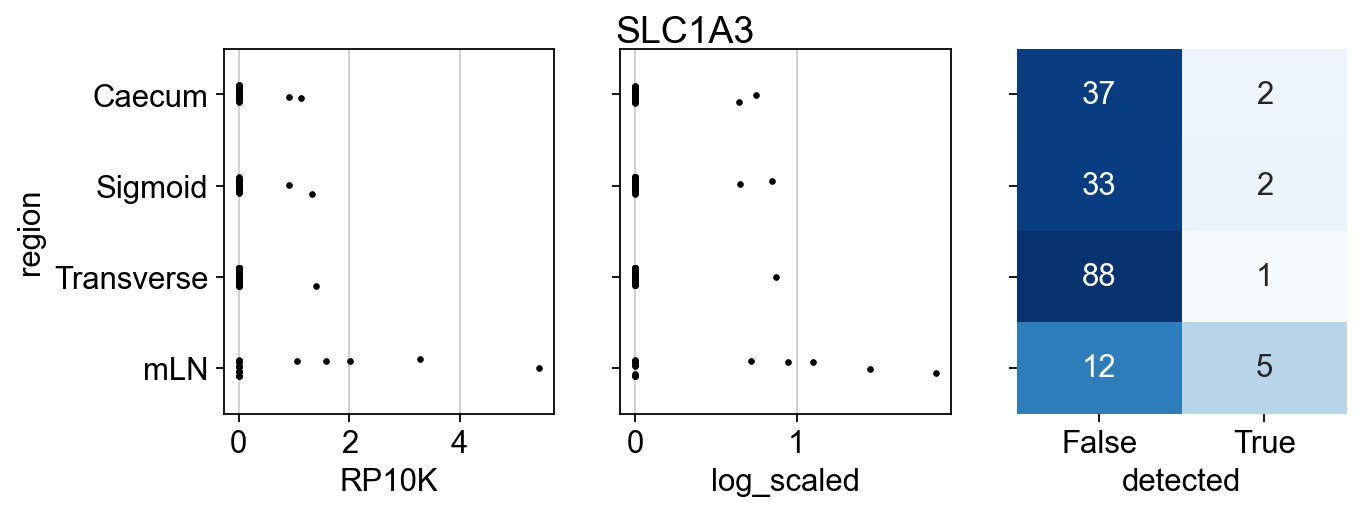

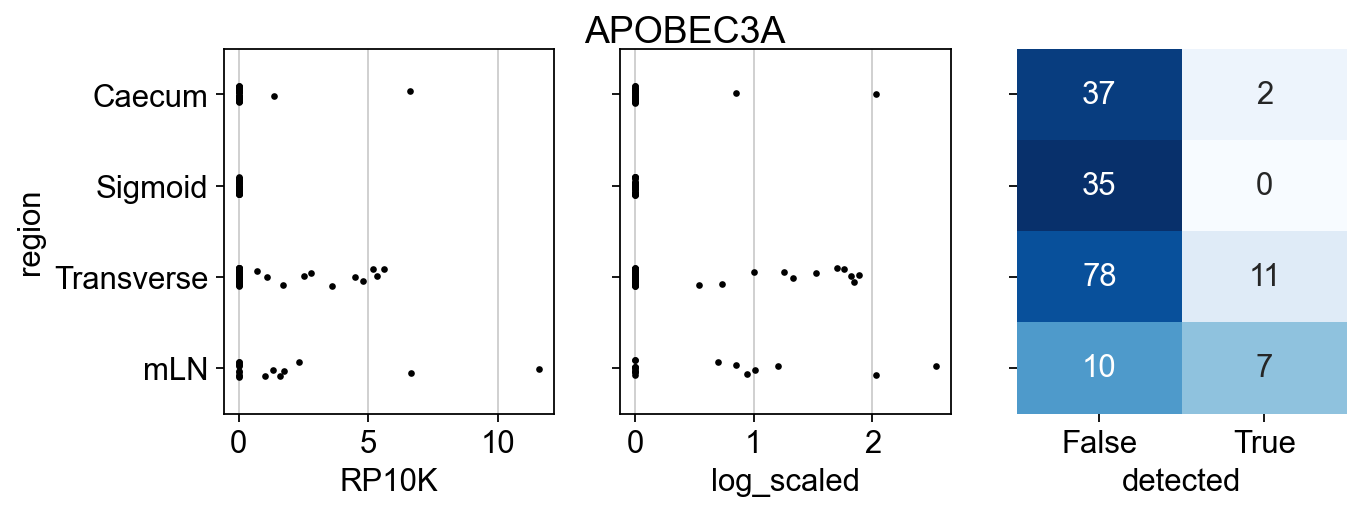

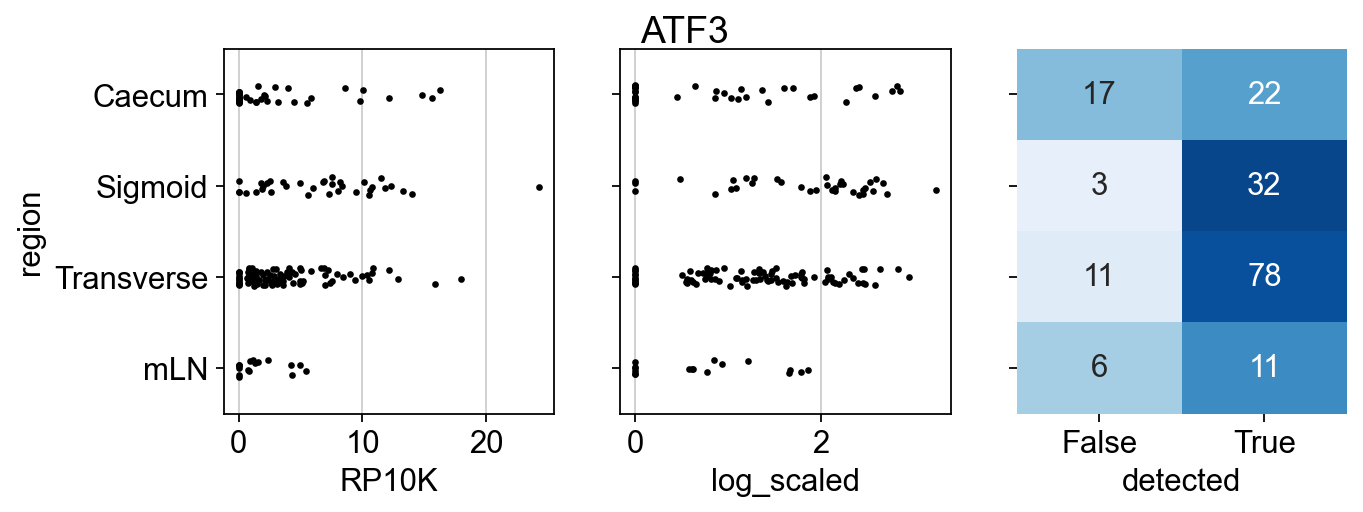

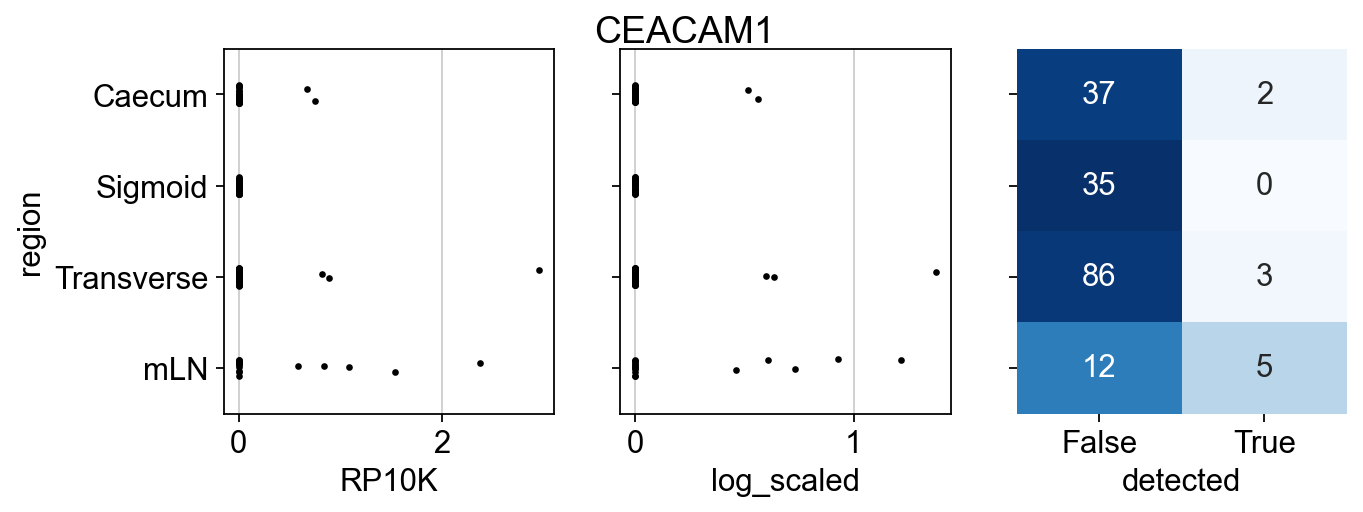

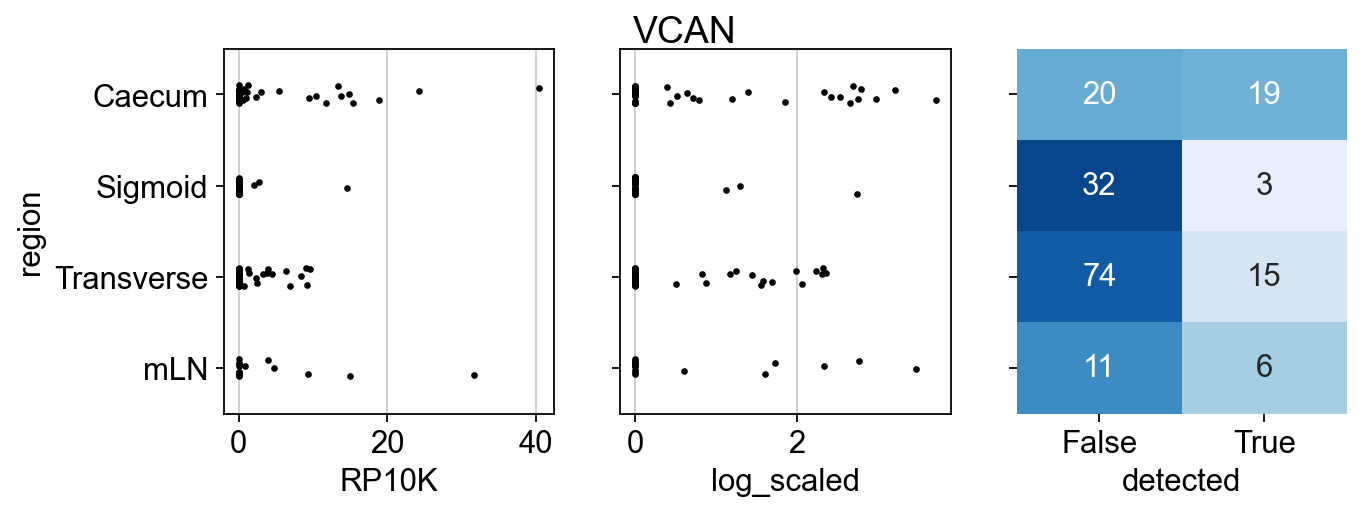

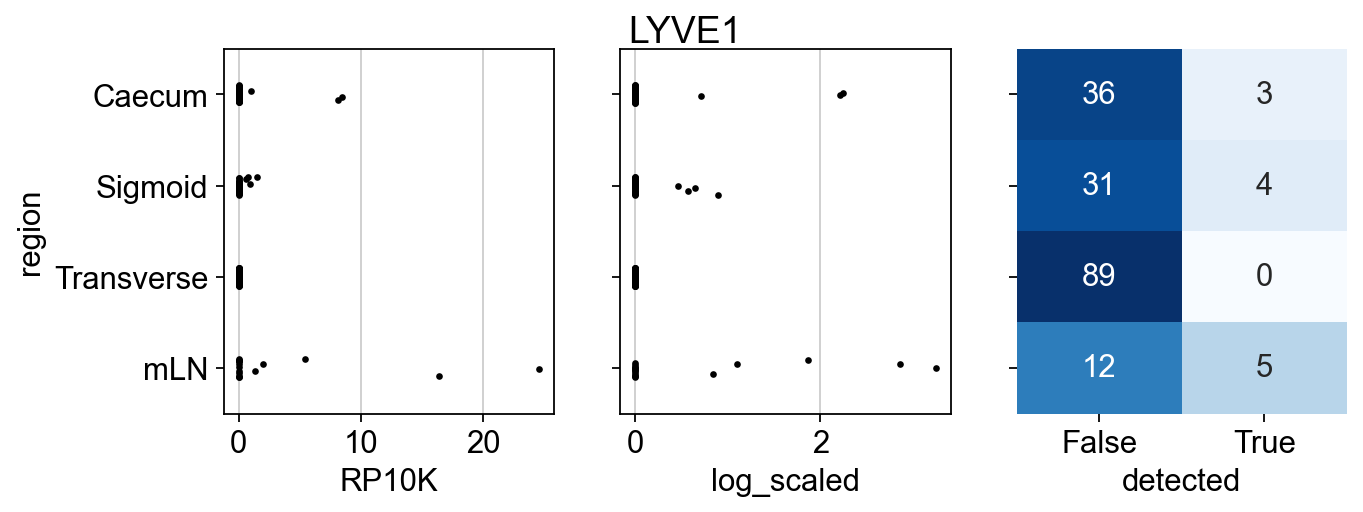

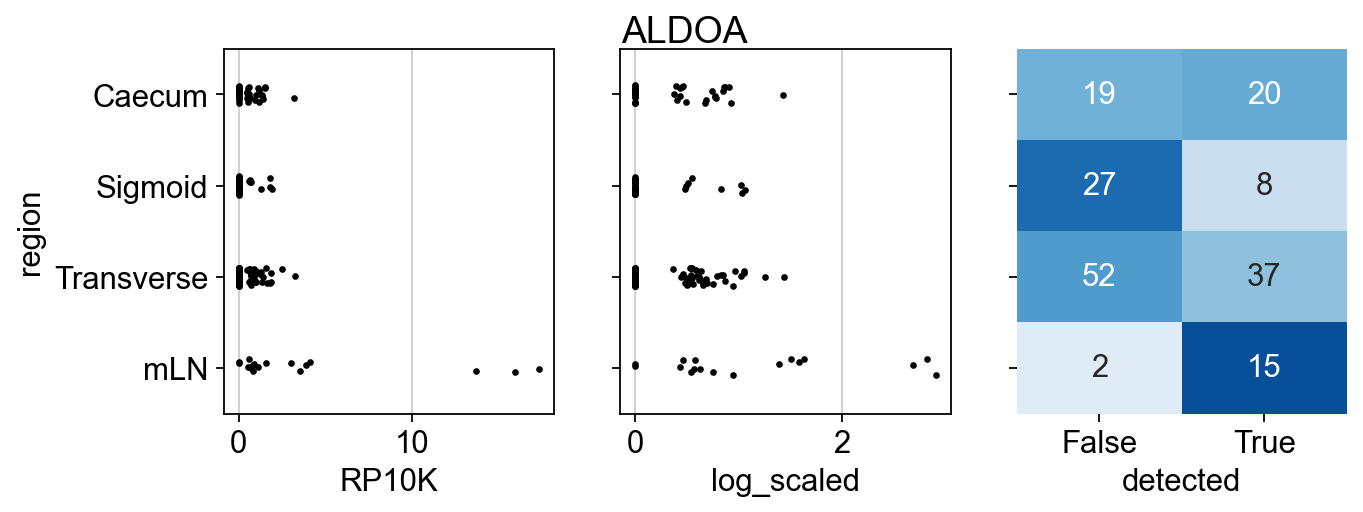

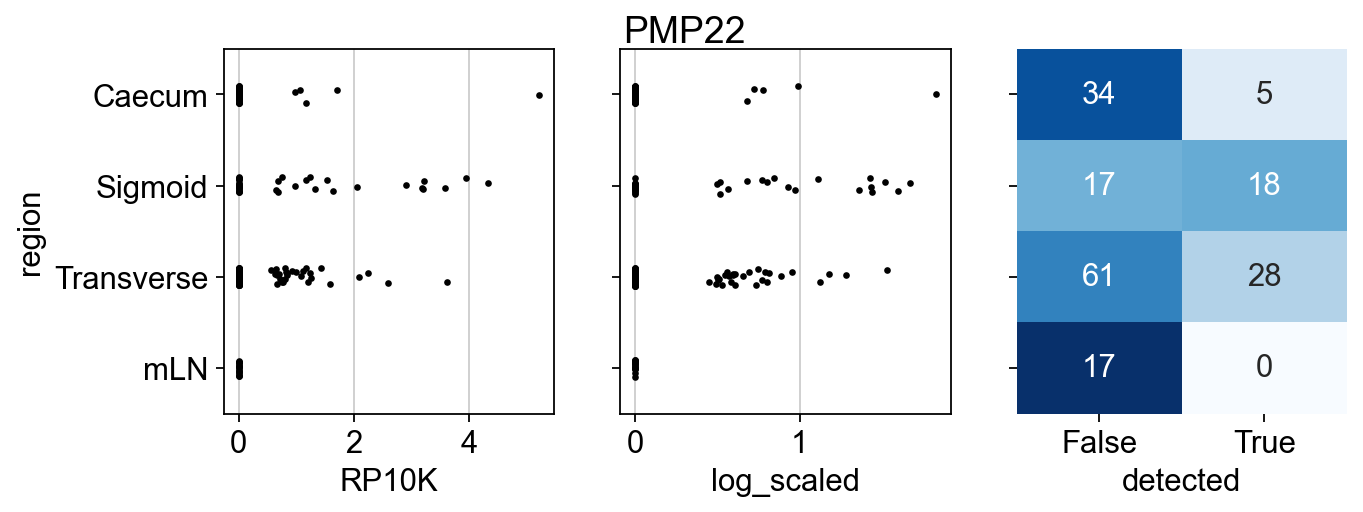

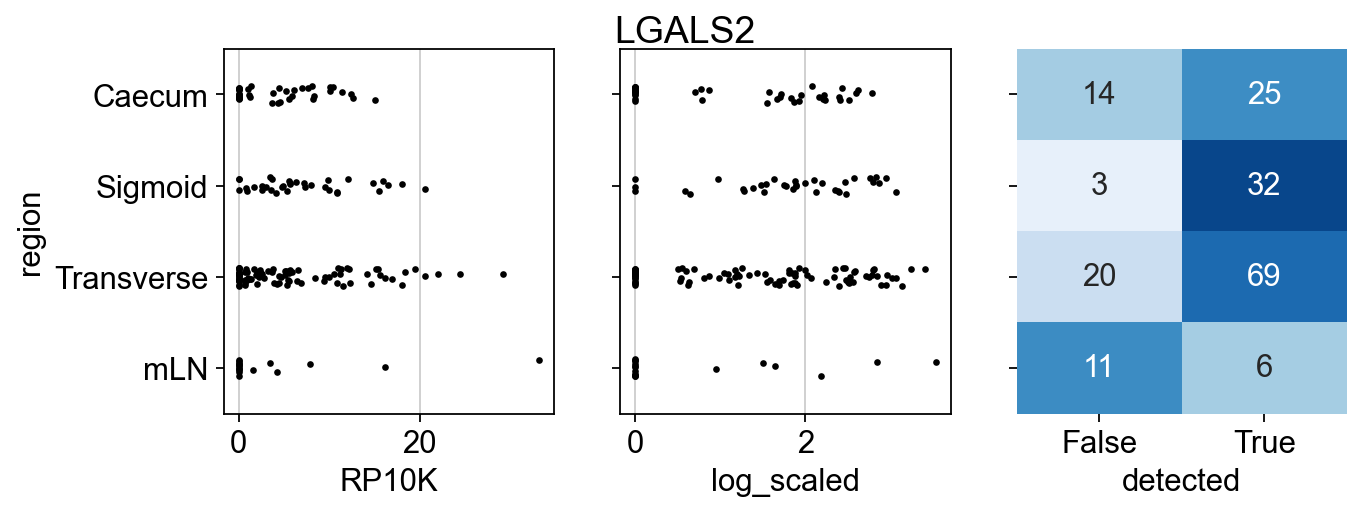

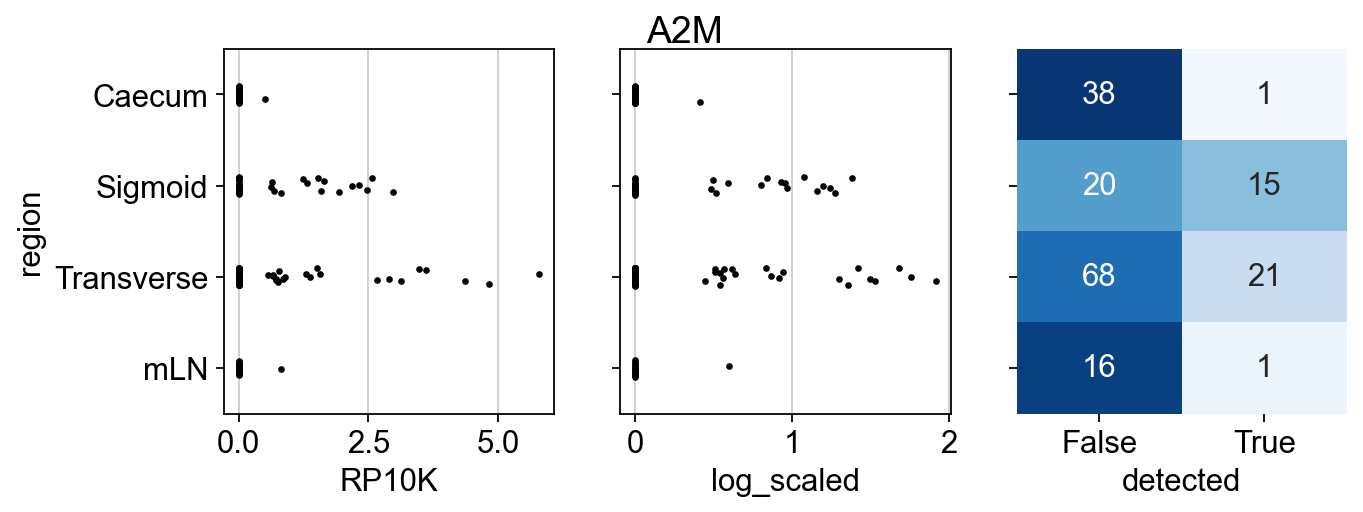

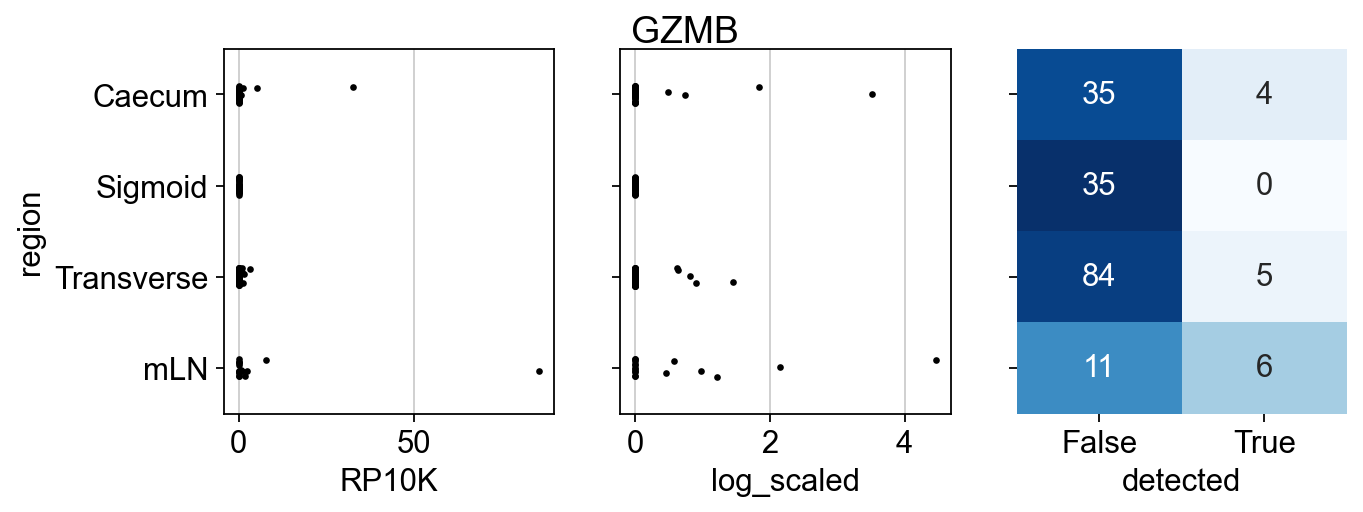

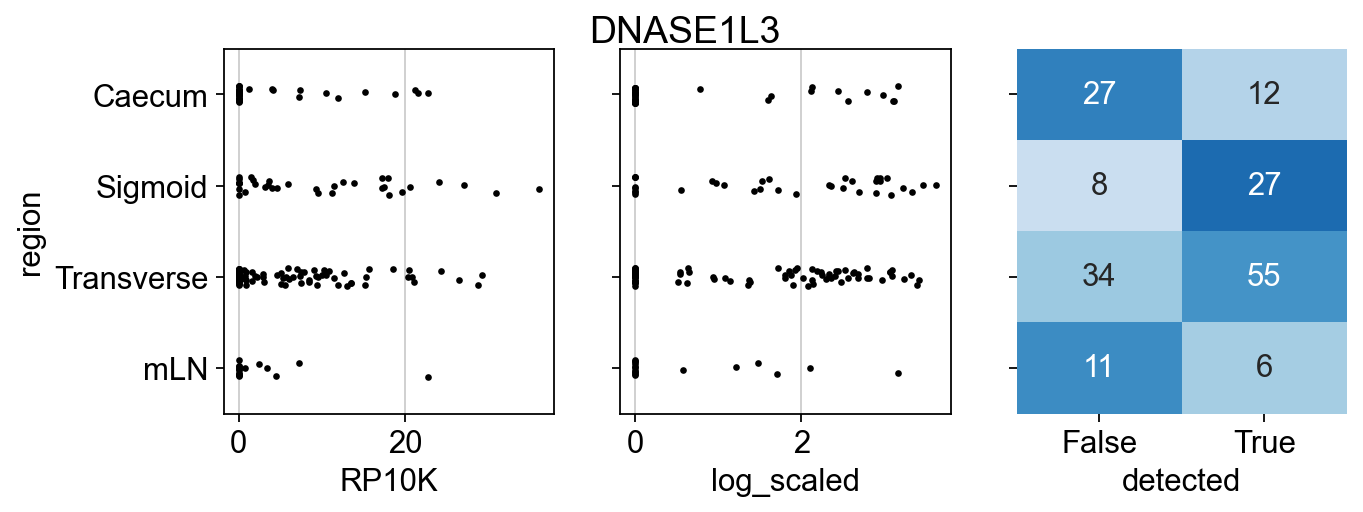

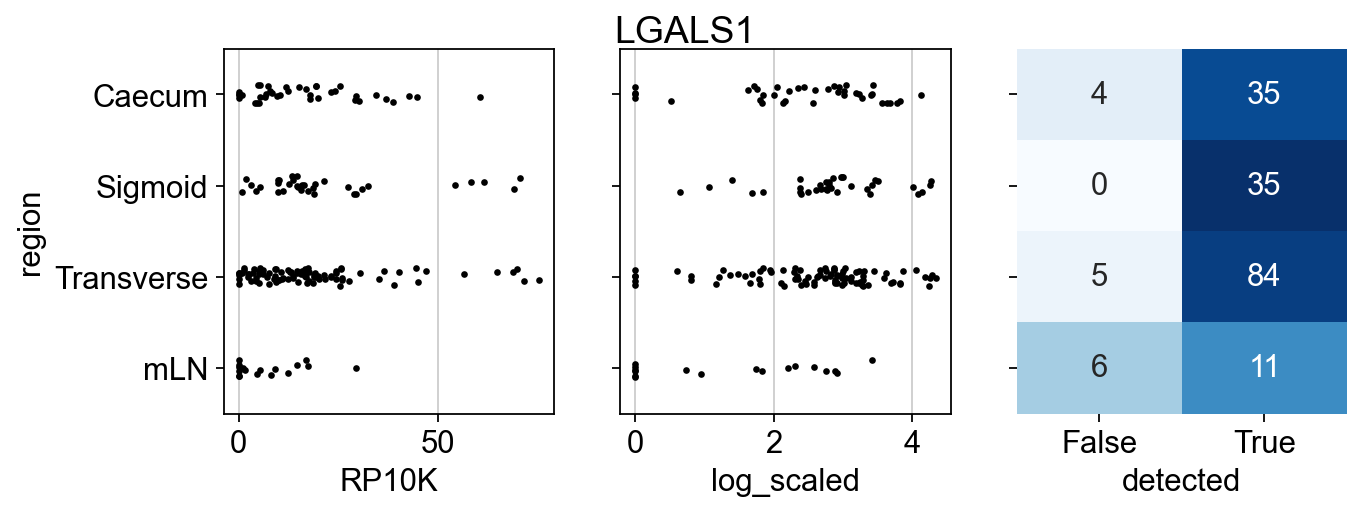

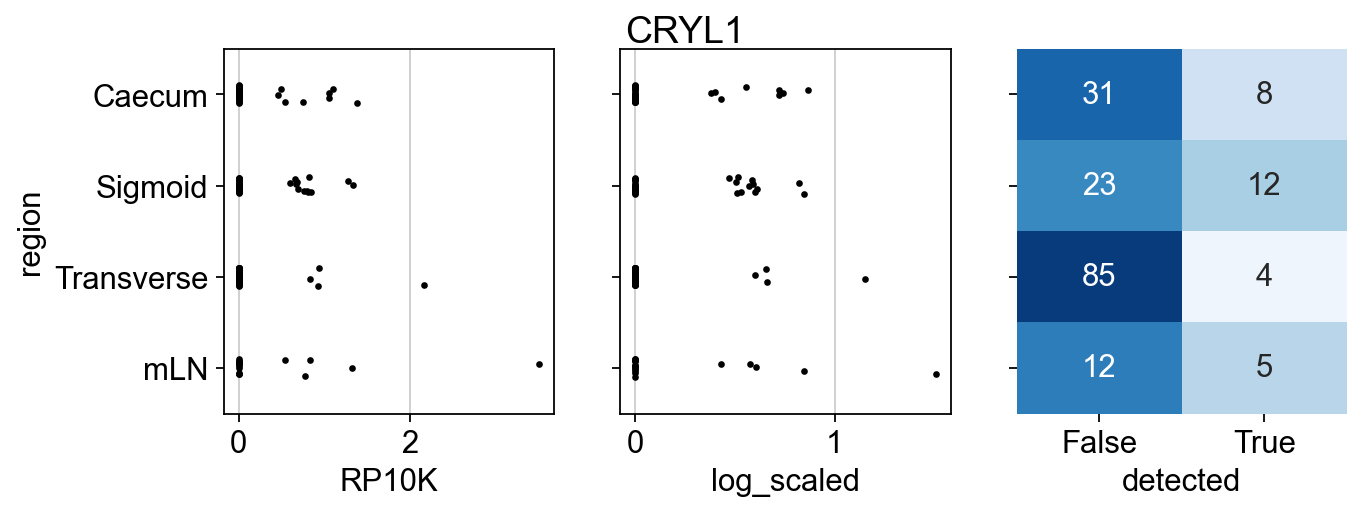

In [18]:
for gene in monocyte_cs_df[
    monocyte_cs_df.q < 0.01
].sort_values('q').gene:
    plot_monocyte_gene(gene)


## GLM: mLN vs not

For argument sake, let's do the generalized linear modeling with a formula:
log_gene_expression ~ Is_mLN


In [19]:
# A dictionary to store the result per gene
monocyte_mLN_GLM = {}
# The variable gene names
monocyte_var_genes = monocyte.var_names[
    monocyte.var.highly_variable
]
# The exogenous 'independent' variable, was this mLN (or not)
monocyte_is_mLN = monocyte.obs.region == 'mLN'
monocyte_is_mLN.name = 'is_mLN'
monocyte_is_mLN = monocyte_is_mLN.astype(int)
# Then add a constant to make our proper exogenous matrix
monocyte_exog = sm.add_constant(
    monocyte_is_mLN
)

for g_i, g_data in enumerate(monocyte[
    :,
    monocyte.var.highly_variable
].X.T):
    # Make our endogenous / outcome vector
    g_data_series = pd.Series(
        np.ravel(g_data.todense()),
        index=monocyte.obs_names,
    )
    m = sm.GLM(
        endog=g_data_series,
        exog=monocyte_exog,
    ).fit()
    monocyte_mLN_GLM[monocyte_var_genes[g_i]] = m


### Looking at a statsmodels fitted model

Here we can see sample output from a statsmodels fitted model. While nice, let's go ahead and convert this into a dataframe so we can do multiple comparison corrections and filter down to 'significant genes', make a volcano plot, etc.


In [20]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  180
Model:                            GLM   Df Residuals:                      178
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                         0.89112
Method:                          IRLS   Log-Likelihood:                -244.03
Date:                Fri, 26 Jan 2024   Deviance:                       158.62
Time:                        13:18:51   Pearson chi2:                     159.
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0006432
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5587      0.074      7.557      0.000       0.414       0.704
is_mLN        -0.0778      0.241     -0.323      0.746      -0.549       0.394
==============================================================================
"""

In [21]:
# use python list comprehension to make a list of dictionaries, and in turn convert into a dataframe
monocyte_mLN_GLM_df = pd.DataFrame(
    [
        {
            'gene': gene,
            'wald': g_m.params['is_mLN'] / g_m.bse['is_mLN'],
            'coef': g_m.params['is_mLN'],
            'bse': g_m.bse['is_mLN'],
            'p': g_m.pvalues['is_mLN'],
        }
        for gene, g_m in monocyte_mLN_GLM.items()
    ]   
)
monocyte_mLN_GLM_df.head(2)

,gene,wald,coef,bse,p
0,NOC2L,-1.327210,-0.112533,0.084789,0.184439
1,HES4,0.041455,0.004846,0.116900,0.966933


In [22]:
# Multiple comparisons correction
monocyte_mLN_GLM_df['q'] = multipletests(
    monocyte_mLN_GLM_df.p,
    method='fdr_bh',
)[1]
monocyte_mLN_GLM_df.head(2)

,gene,wald,coef,bse,p,q
0,NOC2L,-1.327210,-0.112533,0.084789,0.184439,0.496499
1,HES4,0.041455,0.004846,0.116900,0.966933,0.989178


In [23]:
monocyte_mLN_GLM_df[
    monocyte_mLN_GLM_df.q < 0.01
].sort_values('wald')

,gene,wald,coef,bse,p,q
403,JCHAIN,-14.043681,-2.040019,0.145262,8.422160e-45,1.371128e-41
125,FCGR2B,-4.828172,-0.997523,0.206605,1.377921e-06,7.735366e-05
1596,LGALS1,-4.365007,-1.162059,0.266221,1.271184e-05,5.593212e-04
116,FCER1A,-4.058849,-1.360684,0.335239,4.931526e-05,1.859400e-03
1335,CLEC10A,-3.847336,-1.124480,0.292275,1.194091e-04,3.351876e-03
...,...,...,...,...,...,...
1384,NME2,7.334423,0.719472,0.098095,2.226781e-13,6.042000e-11
1284,ALDOA,7.442081,0.865249,0.116264,9.911137e-14,3.227066e-11
1339,GABARAP,7.841456,1.084574,0.138313,4.453517e-15,1.812582e-12
83,NBPF26,8.514631,0.409251,0.048064,1.671220e-17,9.069152e-15


#### Volcano plot using matplotlib

A bit of a vanilla approach but worth seeing an example of..


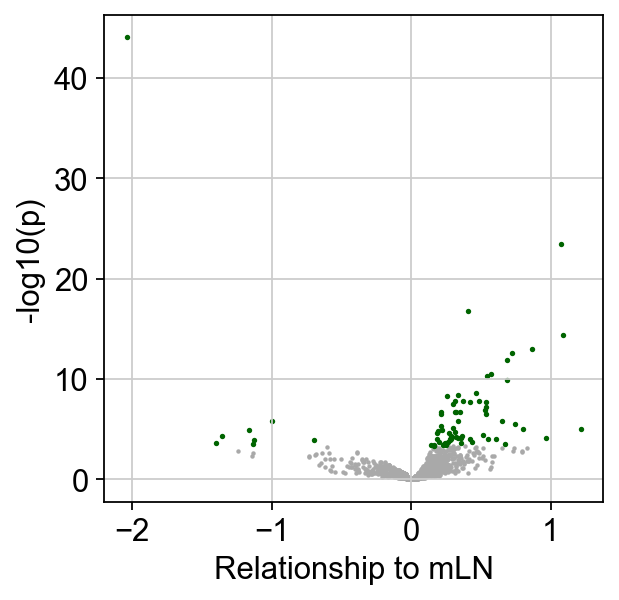

In [24]:
fig, ax = plt.subplots(
    figsize=(4,4),
)
ax.scatter(
    monocyte_mLN_GLM_df[
        monocyte_mLN_GLM_df.q > 0.01
    ].coef,
    -1*np.log10(
        monocyte_mLN_GLM_df[
            monocyte_mLN_GLM_df.q > 0.01
        ].p
    ),
    s=1,
    color='darkgrey',
)
ax.scatter(
    monocyte_mLN_GLM_df[
        monocyte_mLN_GLM_df.q <= 0.01
    ].coef,
    -1*np.log10(
        monocyte_mLN_GLM_df[
            monocyte_mLN_GLM_df.q <= 0.01
        ].p
    ),
    s=2,
    color='darkgreen',
)
ax.set_xlabel("Relationship to mLN")
ax.set_ylabel("-log10(p)")
plt.show()

### Mixed Linear Modeling

This approach *can* correct for repeated sampling. 

In [25]:
# A dictionary to store the result per gene
monocyte_mLN_mlm = {}
# The variable gene names
monocyte_var_genes = monocyte.var_names[
    monocyte.var.highly_variable
]
# The exogenous 'independent' variable, was this mLN (or not)
monocyte_is_mLN = monocyte.obs.region == 'mLN'
monocyte_is_mLN.name = 'is_mLN'
monocyte_is_mLN = monocyte_is_mLN.astype(int)
# Then add a constant to make our proper exogenous matrix
monocyte_exog = sm.add_constant(
    monocyte_is_mLN
)

for g_i, g_data in enumerate(monocyte[
    :,
    monocyte.var.highly_variable
].X.T):
    # Make our endogenous / outcome vector
    g_data_series = pd.Series(
        np.ravel(g_data.todense()),
        index=monocyte.obs_names,
    )
    m = sm.MixedLM(
        endog=g_data_series,
        exog=monocyte_exog,
        groups=monocyte.obs.donor,
    ).fit()
    if m.converged:
        monocyte_mLN_mlm[monocyte_var_genes[g_i]] = m
        

/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

In [26]:
m.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: y        
No. Observations: 180     Method:             REML     
No. Groups:       4       Scale:              0.8394   
Min. group size:  7       Log-Likelihood:     -243.2224
Max. group size:  113     Converged:          No       
Mean group size:  45.0                                 
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
const      0.431     0.219  1.968  0.049   0.002   0.861
is_mLN     0.084     0.280  0.301  0.763  -0.464   0.633
Group Var  0.126     0.141                              
=======================================================

"""

In [27]:
# use python list comprehension to make a list of dictionaries, and in turn convert into a dataframe
monocyte_mLN_mlm_df = pd.DataFrame(
    [
        {
            'gene': gene,
            'wald': g_m.params['is_mLN'] / g_m.bse['is_mLN'],
            'coef': g_m.params['is_mLN'],
            'bse': g_m.bse['is_mLN'],
            'p': g_m.pvalues['is_mLN'],
        }
        for gene, g_m in monocyte_mLN_mlm.items()
    ]   
)
monocyte_mLN_mlm_df.head(2)

,gene,wald,coef,bse,p
0,HES4,0.040354,0.004847,0.120100,0.967811
1,KCNAB2,0.641600,0.070816,0.110374,0.521133


In [28]:
# Get rid of genes where there was no p-value determinable by the techinque
monocyte_mLN_mlm_df =  monocyte_mLN_mlm_df[
    ~monocyte_mLN_mlm_df.p.isna()
].copy()

monocyte_mLN_mlm_df.head()

,gene,wald,coef,bse,p
0,HES4,0.040354,0.004847,0.120100,0.967811
1,KCNAB2,0.641600,0.070816,0.110374,0.521133
2,TNFRSF9,-0.298272,-0.013798,0.046261,0.765496
3,RBP7,-0.228268,-0.013324,0.058369,0.819438
4,KIF1B,-0.154257,-0.010623,0.068864,0.877407


In [29]:
# Multiple comparisons correction
monocyte_mLN_mlm_df['q'] = multipletests(
    monocyte_mLN_mlm_df.p,
    method='fdr_bh',
)[1]
monocyte_mLN_mlm_df.head(2)

,gene,wald,coef,bse,p,q
0,HES4,0.040354,0.004847,0.120100,0.967811,0.993371
1,KCNAB2,0.641600,0.070816,0.110374,0.521133,0.877163


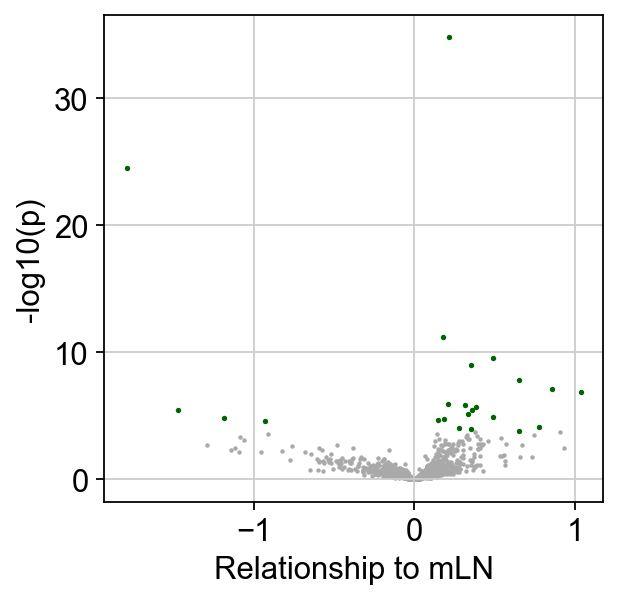

In [31]:
fig, ax = plt.subplots(
    figsize=(4,4),
)
ax.scatter(
    monocyte_mLN_mlm_df[
        monocyte_mLN_mlm_df.q > 0.01
    ].coef,
    -1*np.log10(
        monocyte_mLN_mlm_df[
            monocyte_mLN_mlm_df.q > 0.01
        ].p
    ),
    s=1,
    color='darkgrey',
)
ax.scatter(
    monocyte_mLN_mlm_df[
        monocyte_mLN_mlm_df.q <= 0.01
    ].coef,
    -1*np.log10(
        monocyte_mLN_mlm_df[
            monocyte_mLN_mlm_df.q <= 0.01
        ].p
    ),
    s=2,
    color='darkgreen',
)
ax.set_xlabel("Relationship to mLN")
ax.set_ylabel("-log10(p)")
plt.show()

In [30]:
monocyte_mLN_mlm_df[
    monocyte_mLN_mlm_df.q < 0.01
].sort_values('wald')

,gene,wald,coef,bse,p,q
341,JCHAIN,-10.380475,-1.789349,0.172376,3.042582e-25,2.106988e-22
1364,LGALS1,-4.639768,-1.472386,0.317340,3.488001e-06,3.716063e-04
557,HSPB1,-4.335030,-1.186395,0.273676,1.457406e-05,1.261567e-03
104,FCGR2B,-4.233924,-0.929739,0.219593,2.296486e-05,1.674017e-03
877,DUSP5,3.798400,0.650447,0.171242,1.456329e-04,8.769633e-03
1257,R3HDM4,3.871046,0.355637,0.091871,1.083693e-04,6.822339e-03
1225,NFATC1,3.931588,0.280680,0.071391,8.438673e-05,5.565506e-03
1026,GPR65,3.957353,0.776533,0.196225,7.578495e-05,5.248108e-03
1161,CPD,4.252781,0.147018,0.034570,2.111324e-05,1.624546e-03
732,SUSD1,4.301387,0.184587,0.042913,1.697323e-05,1.382819e-03
